<a href="https://colab.research.google.com/github/radicaljims/colab_notebooks/blob/master/Brunton/Brunton_chapter1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Okay, so here is where I start typing in things from Brunton and Kutz's book.

This notebook will be about Chapter 1 which is all about the singular value decomposition (SVD).

# Background

The authors relate it to the Fourier Transform in that both operations decompose their inputs into a new basis. A difference is the basis provided by the SVD is "tailored" and depends on the input; whereas the FT uses a fixed basis of exponentials.

For the SVD, that basis is one which maximally *decorrelates* the input, or something to that effect.

What makes the technique so applicable:

  * physical data can often be meaningfully aggregated into matrices
  * the same data is often *low rank*, which means there are relatively few subspaces that capture most of the "information"

That last bullet point also implies that if we can isolate those subspaces (which are spanned by sets of column vectors) then we can perform do some dimensional reduction without damaging the accuracy of our results too much.

The SVD finds a "natural" basis for the data matrix, with the basis elements ordered by how much "information" they capture. This means if the data is low enough rank, r << n (n is the original dimension of the data), truncating the SVD basis and keeping just the first r basis elements yields a compressed representation.

It turns out this approximation has the smallest possible error in some least-squares sense. I'll try to write that down when we get to it.

Other applications of the SVD include:

  * computing the pseudo-inverse of a matrix
  * de-noising data sets
  * characterizing the geometry of linear maps

# Definition

Maybe hard to write here, does this support latex?

# Computing the SVD

Easy to do with `numpy`:




In [0]:
import numpy as np
X = np.random.rand(5, 3)
U, S, V = np.linalg.svd(X, full_matrices=True)     # There's almost always a lower dimensional matrix you can use that strips out columns with singular value 0
U_, S_, V_ = np.linalg.svd(X, full_matrices=False) # That's what this one returns, aka the "economy SVD"

# Other Uses

The SVD is also used in the following:
 
   * Principal component analysis (PCA) in statistics
   * The Karhunen-Loeve transform (KLT) (used in JPEG?)
   * Proper orthogonal decomposition (POD) in fluid dynamics
   * Canonical correlation analysis (CCA) 
   * Control theory! To compress models or something

# Matrix Approximation

As mentioned above, the SVD provides an *optimal* low-rank approximation to a matrix **X**.

This was apparently discovered by Schmidt, but later re-discovered by Eckart and Young so it's called

**Theorem 1 (Eckart-Young)**. *The optimal rank-r approximation to X, in a least-squares sense, is given by the rank-r SVD truncation $\tilde{X}$:*

$\text{argmin } \mid X - \tilde{X} \mid_{F} = \tilde{U} \tilde{\Sigma} \tilde{V}^{*}, \text{ s.t. rank}(\tilde{X}) = r$

*Here $\tilde{U}$ and $\tilde{V}$ denote the first r leading columns of U and V, and $\tilde{\Sigma}$ contains the leading r x r sub-block of $\Sigma$. $\mid \cdot \mid_{F}$ is the Frobenius norm.*

# Example: Image Compression


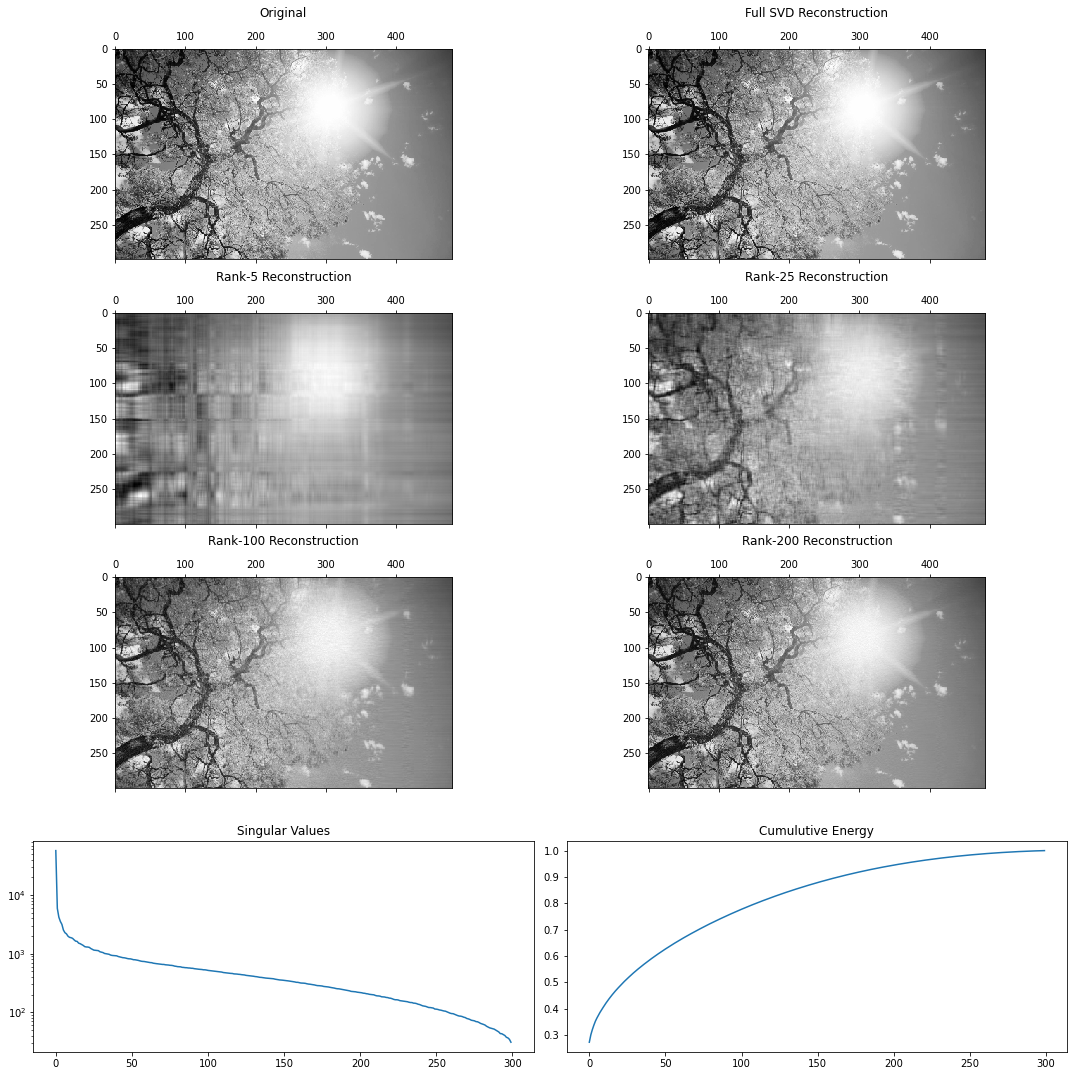

In [53]:
# Note: using the following as a reference (and overall source of inspiration!): https://colab.research.google.com/github/bartwronski/BlogPostsExtraMaterial/blob/master/blue_noise_optimize_fft.ipynb#scrollTo=n3TPNq7Vl4Do
import urllib
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os
import os.path
import cv2

import numpy as np

urllib.request.urlretrieve('https://www.dropbox.com/s/79uilyp1ifhetp1/pretty_picture.png?dl=1', filename='pretty_picture.png')
big_boy = cv2.imread('pretty_picture.png')

# Shrink the image so we don't run out of RAM later (we hope)
small_boy = cv2.resize(big_boy, None, fx=0.25, fy=0.25)

# BGR -> grayscale, lightweight dimensional reduction :)
grey_boy = cv2.cvtColor(small_boy, cv2.COLOR_BGR2GRAY)

# Note: numpy seems to return slightly different matrices than the book describes
# Instead of X = USV*, it is USV - the V comes in already transposed
u, s, v = np.linalg.svd(grey_boy, full_matrices=True)

# For reasons I guess I should be able to understand, simply doing the following
# only works for rectangular matrices (like if I were using the economy SVD I suppose)
# Oh, it's probably because the `diag` is generating an `n x n` instead of `n x m` matrix
#should_be_g = np.matmul(u, np.matmul(np.diag(s), v))

m, n = grey_boy.shape
should_be_g = u[:, :n] @ np.diag(s) @ v[:m, :]

# Now we can generate some truncated approximations to the SVD and look at how close they are
def truncate(u, s, v, r):
  return u[:, :r] @ np.diag(s[:r]) @ v[:r,:]

sample_ranks = [5, 25, 100, 200]
truncations = [truncate(u, s, v, r) for r in sample_ranks]

fig, axs = plt.subplots(4, 2)
axs[0, 0].matshow(grey_boy, cmap="gray")
axs[0, 0].set_title("Original\n")

axs[0, 1].matshow(should_be_g, cmap="gray")
axs[0, 1].set_title("Full SVD Reconstruction\n")

row=1
for idx, t in enumerate(truncations):
  axs[row, idx % 2].set_title("Rank-%s Reconstruction\n" % sample_ranks[idx])
  axs[row, idx % 2].matshow(t, cmap="gray")
  
  row = row + (idx % 2)

# There's probably some way to make this just work in matplotlib
#axs[3, 0].semilogy(np.diag(s))

# But I don't know how, so gonna try to do it by hand
xs, ys = [], []
for idx, v in enumerate(s):
  xs.append(idx)
  ys.append(v)

axs[3, 0].semilogy(xs, ys)
axs[3, 0].set_title("Singular Values")

axs[3, 1].plot(xs, np.cumsum(ys) / sum(ys))
axs[3, 1].set_title("Cumulutive Energy")

fig.tight_layout(pad=1.0)
plt.show()

Looking at the images we can visually see that a relatively low-rank approximation captures a lot of the image; the 25-dimensional one already looks pretty good, at least to me.

And I can't even tell the difference between the 100- and 200-dimensional images. Maybe some of the clouds are a bit more detailed.

Now, each orthogonal eigenvector is sometimes called a *mode*, and looking at the magnitude of the corresponding eigenvalue is sometimes called the *energy*.

# Mathematical Properties and Manipulations

The goal in this section is to describe some mathematical properties of the SVD and provide a geometric interpretation of the matrices $U$ and $V$.

## Interpretations as Dominant Correlations

There are the following relationships between the SVD decomposition and the correlation matrices $XX^{*}$ and $X^{*}X$:

\begin{align}
XX^{*} &= U \begin{bmatrix} \hat{\Sigma} \\ 0 \end{bmatrix} V^{*}V \begin{bmatrix}\hat{\Sigma} & 0\end{bmatrix} U^{*} = U \begin{bmatrix} \hat{\Sigma}^{2} & 0 \\ 0 & 0 \end{bmatrix} U^{*} \\
X^{*}X &= V \begin{bmatrix}\hat{\Sigma} & 0 \end{bmatrix} UU^{*} \begin{bmatrix}\hat{\Sigma} \\ 0 \end{bmatrix} V^{*} = V\hat{\Sigma}^{2}V^{*}
\end{align}

In words, $XX^{*}$ is formed by taking the inner product of rows of $X$ and $X^{*}X$ by taking inner products of columns of $X$. The equations above express that in terms of the SVD factorization.

Those equations arise from the following eigenvalue problem:

\begin{align}
XX^{*}U &= U \begin{bmatrix} \hat{\Sigma}^{2} & 0 \\ 0 & 0 \\ \end{bmatrix}, \\
X^{*}XV &= V \hat{\Sigma}^{2}.
\end{align}

Again in words, the columns of $U$ are eigenvectors of the correlation matrix $XX^{*}$ and the columns of $V$ are eigenvectors of $X^{*}X$. Ordering the singular values by decreasing magnitude, the columns of $U$ are ordered by how much of the correlation they capture in the columns of $X$; columns of $V$ by how much correlation in the rows of $X$.

Let's look at some pictures of the correlation matrices.

# TODO: figure out how to reference earlier cells